#DTSA 5511 Week 5 GAN project: I’m Something of a Painter Myself
## Use GANs to create art - will you be the next Monet?
Sarah McEliece 04/28/23

# About and Citations
The project and dataset are taken from the kaggle competetion:

Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

They describe the project as:


> 
>We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!
>
>Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

As suggested in the kaggle project notes, I also relied heavily on and took code snippets from Amy Jang's notebook that goes over the basics of loading data from TFRecords, using TPUs, and building a CycleGAN specifically for loading and outputting data. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook



# Download neccesary packages and get data

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import random

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2.11.0


In [3]:
! pip install tensorflow_addons
import tensorflow_addons as tfa

In [4]:
#code to import data slightly adjusted from notebook cited above
GCS_PATH = '/kaggle/input/gan-getting-started'


MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Monet TFRecord Files: 5
Photo TFRecord Files: 20


# EDA

In [5]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

# Now I'll just peak at what a raw data file looks like

In [7]:
print(next(iter(monet_ds))[0])

tf.Tensor(
[[[ 0.082353   -0.01960784 -0.16862744]
  [-0.03529412 -0.1372549  -0.2862745 ]
  [-0.12156862 -0.20784312 -0.3490196 ]
  ...
  [-0.09019607 -0.20784312 -0.46666664]
  [-0.12156862 -0.23137254 -0.52156866]
  [-0.15294117 -0.26274508 -0.5529412 ]]

 [[ 0.11372554  0.01176476 -0.1372549 ]
  [ 0.05882359 -0.04313725 -0.19215685]
  [ 0.0196079  -0.06666666 -0.20784312]
  ...
  [ 0.06666672 -0.05098039 -0.3098039 ]
  [ 0.0196079  -0.09019607 -0.38039213]
  [-0.02745098 -0.1372549  -0.42745095]]

 [[ 0.10588241  0.00392163 -0.14509803]
  [ 0.10588241  0.00392163 -0.14509803]
  [ 0.12156868  0.03529418 -0.10588235]
  ...
  [ 0.17647064  0.05882359 -0.19999999]
  [ 0.11372554  0.00392163 -0.27058822]
  [ 0.05882359 -0.05098039 -0.34117645]]

 ...

 [[-0.20784312 -0.3098039  -0.56078434]
  [-0.0745098  -0.17647058 -0.42745095]
  [-0.17647058 -0.2862745  -0.5137255 ]
  ...
  [-0.00392157 -0.14509803 -0.44313723]
  [-0.03529412 -0.17647058 -0.47450978]
  [-0.04313725 -0.18431371 -0.482

As expected from the data description we have images of shape 256 X 256 with 3-dimensions, since these are RBG type images.

# Creating Discriminator and Generator
As a starting point I'm going to use the DCGAN disciminator and generators we covered in lecture from https://keras.io/examples/generative/dcgan_overriding_train_step/


In [15]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 dropout_5 (Dropout)         (None, 128, 128, 64)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)     

In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn 
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [17]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                 reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                      reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss)/2

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                            reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss2 = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss2

#Building the cycle

In [18]:
generator = keras.Sequential(
     
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.6),
        layers.Conv2D(256, kernel_size=3, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, kernel_size=3, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.6),
        layers.Conv2D(512, kernel_size=3, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.6),
        layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.6),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="tanh"),
    ],
    name="generator",
)


generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      3136      
                                                                 
 batch_normalization_9 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_10 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 64, 64, 128)       0 

Epoch 1/75


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5677: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits, "Sigmoid", "binary_crossentropy"
2023-04-30 16:35:53.548548: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator/dropout_5/dropout_1/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 60s 138ms/step - monet_gen_loss: 10.6531 - photo_gen_loss: 10.8983 - monet_disc_loss: 0.5980 - photo_disc_loss: 0.4638
Epoch 2/75
300/300 [==============================] - 42s 138ms/step - monet_gen_loss: 9.4751 - photo_gen_loss: 9.6563 - monet_disc_loss: 0.6158 - photo_disc_loss: 0.5356
Epoch 3/75
300/300 [==============================] - 42s 139ms/step - monet_gen_loss: 9.2678 - photo_gen_loss: 9.4368 - monet_disc_loss: 0.5804 - photo_disc_loss: 0.5326
Epoch 4/75
300/300 [==============================] - 41s 138ms/step - monet_gen_loss: 9.1926 - photo_gen_loss: 9.3305 - monet_disc_loss: 0.5602 - photo_disc_loss: 0.4710
Epoch 5/75
300/300 [==============================] - 42s 140ms/step - monet_gen_loss: 9.1110 - photo_gen_loss: 9.2853 - monet_disc_loss: 0.5614 - photo_disc_loss: 0.4595
Epoch 6/75
300/300 [==============================] - 42s 140ms/step - monet_gen_loss: 8.8453 - photo_gen_loss: 8.9838 - monet_disc_loss: 0.5989 - photo_d

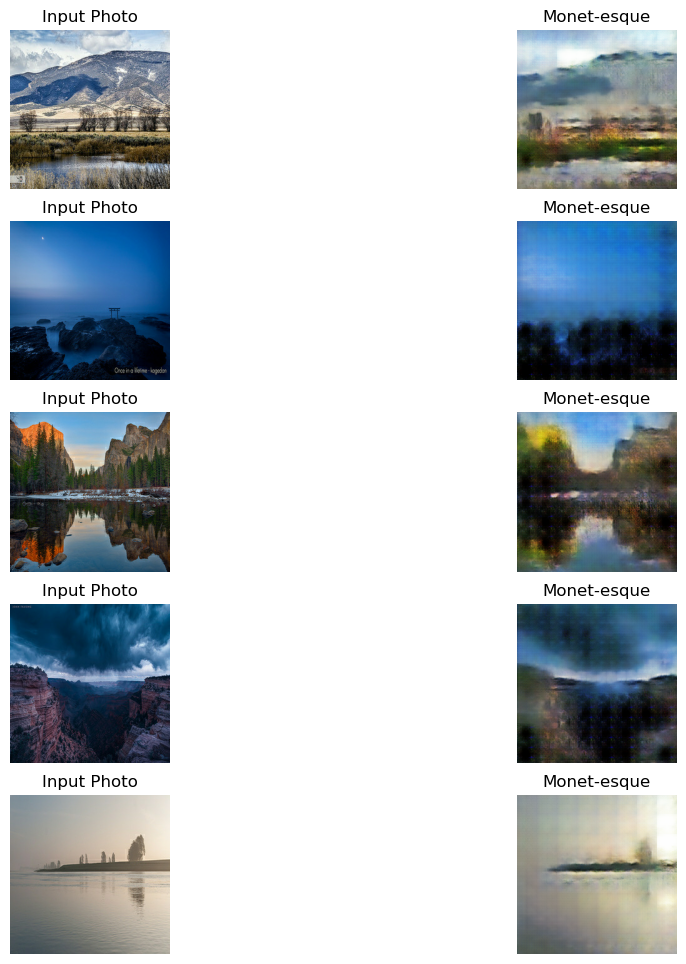

In [19]:
monet_gen = generator
photo_gen = generator
monet_dis = discriminator
photo_dis = discriminator 

monet_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
photo_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
monet_d_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
photo_d_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)


cycle_gan_model = CycleGan(monet_gen, photo_gen, monet_dis, photo_dis)
cycle_gan_model.compile(monet_g_optimizer,photo_g_optimizer,monet_d_optimizer,
                        photo_d_optimizer, generator_loss, discriminator_loss, cycle_loss, identity_loss)

cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)),epochs=75)

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [1]:
import PIL
! mkdir ../images

In [2]:
i = 1
for img in photo_ds:
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

NameError: name 'photo_ds' is not defined

In [27]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'